<a href="https://colab.research.google.com/github/mdonbruce/AspNetDocs/blob/master/NumPy_to_sklearn_Feature_Pipelines_EXECUTED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧪 NumPy → scikit-learn Feature Pipelines
### Mini-Labs Overview (Interactive Colab Lecture)

**You will:**
- Review NumPy arrays, slicing, masking, and vectorization
- Create ML features using NumPy (no loops)
- Build a scikit-learn `Pipeline` with preprocessing + model

**Files:**
- `transactions_pipeline_large.csv`


## ✅ Colab Setup
1. Upload the CSV: **Files → Upload → transactions_pipeline_large.csv**
2. Run cells top-to-bottom.

**Tip:** If you see a `FileNotFoundError`, check the filename in the Colab file pane.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('transactions_pipeline_large.csv', parse_dates=['timestamp'])
print('Dataset shape:', df.shape)
display(df.head())


Dataset shape: (80000, 12)


,transaction_id,timestamp,price,quantity,discount_rate,region,channel,device_type,customer_age,loyalty_tier,is_returning,is_fraud
0,1,2026-01-27 09:46:00,13.31,6,0.09,North,in_store,mobile,68,Gold,1,0
1,2,2026-01-06 13:07:00,11.14,8,0.09,West,online,tablet,71,Platinum,1,0
2,3,2026-01-01 19:39:00,52.91,8,0.00,North,online,desktop,51,Gold,1,0
3,4,2026-01-20 20:05:00,20.33,1,0.26,West,in_store,kiosk,60,Bronze,1,0
4,5,2026-01-12 07:54:00,41.07,8,0.20,East,in_store,tablet,70,Silver,1,0


## Mini-Lab 1 — Array Fundamentals
**Goal:** Treat tabular data as a matrix.

We will create a feature matrix `A` from numeric columns.


In [2]:
A = df[['price','quantity','discount_rate','customer_age','is_returning']].values
print('A shape:', A.shape)
print('A dtype:', A.dtype)


A shape: (80000, 5)
A dtype: float64


**Checkpoint:**
- Rows = transactions (examples)
- Columns = numeric features


## Mini-Lab 2 — Indexing & Slicing
**Goal:** Extract subsets efficiently.

We will:
- Slice a sample
- Use a boolean mask to filter high-price transactions


In [3]:
A_sample = A[:5]
display(A_sample)

# High-price filter (vectorized)
high_price_mask = df['price'].to_numpy() > 250
df_high_price = df[high_price_mask]
print('High-price rows:', df_high_price.shape[0])


array([[13.31,  6.  ,  0.09, 68.  ,  1.  ],
       [11.14,  8.  ,  0.09, 71.  ,  1.  ],
       [52.91,  8.  ,  0.  , 51.  ,  1.  ],
       [20.33,  1.  ,  0.26, 60.  ,  1.  ],
       [41.07,  8.  ,  0.2 , 70.  ,  1.  ]])

High-price rows: 13


**Discuss:** Why is boolean masking a better choice than `for` loops for large datasets?


## Mini-Lab 3 — Vectorized Operations
**Goal:** Compute revenue without loops.

Revenue per transaction:
$$ revenue = price \times quantity \times (1 - discount\_rate) $$


In [4]:
price = df['price'].to_numpy(dtype=float)
qty = df['quantity'].to_numpy(dtype=float)
disc = df['discount_rate'].to_numpy(dtype=float)

revenue = price * qty * (1 - disc)
print('Total revenue (vectorized):', revenue.sum())


Total revenue (vectorized): 14949261.171100002


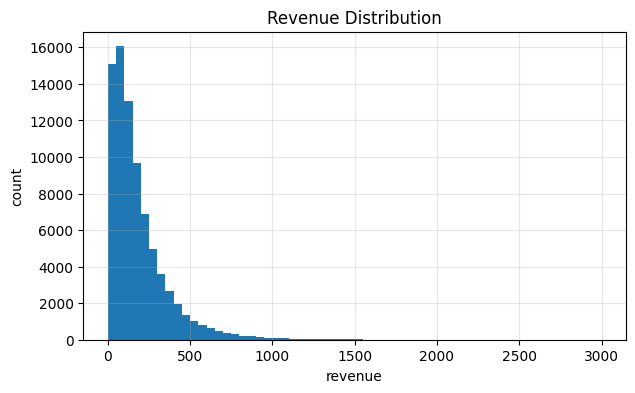

In [5]:
plt.figure(figsize=(7,4))
plt.hist(revenue, bins=60)
plt.title('Revenue Distribution')
plt.xlabel('revenue')
plt.ylabel('count')
plt.grid(True, alpha=0.3)
plt.show()


## Mini-Lab 4 — NumPy Feature Engineering
**Goal:** Create new features that improve ML signal.

We add:
- `revenue`
- `log_revenue = log1p(revenue)`
- `discount_amt`
- `unit_price_after_disc`


In [6]:
df2 = df.copy()
df2['revenue'] = revenue
df2['log_revenue'] = np.log1p(revenue)
df2['discount_amt'] = price * qty * disc
df2['unit_price_after_disc'] = price * (1 - disc)

display(df2[['price','quantity','discount_rate','revenue','log_revenue','discount_amt','unit_price_after_disc']].head())


,price,quantity,discount_rate,revenue,log_revenue,discount_amt,unit_price_after_disc
0,13.31,6,0.09,72.6726,4.299631,7.1874,12.1121
1,11.14,8,0.09,81.0992,4.407928,8.0208,10.1374
2,52.91,8,0.00,423.2800,6.050394,0.0000,52.9100
3,20.33,1,0.26,15.0442,2.775347,5.2858,15.0442
4,41.07,8,0.20,262.8480,5.575373,65.7120,32.8560


## Mini-Lab 5 — scikit-learn Feature Pipeline
**Goal:** Train a baseline model with a **reproducible** pipeline.

Pipeline structure:
1) Split train/test
2) Preprocess numeric + categorical columns
3) Fit model
4) Evaluate metrics


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Target
y = df2['is_fraud']
# Features (drop timestamp for baseline)
X = df2.drop(columns=['is_fraud','timestamp'])

numeric = ['price','quantity','discount_rate','customer_age','is_returning',
           'revenue','log_revenue','discount_amt','unit_price_after_disc']
categorical = ['region','channel','device_type','loyalty_tier']

pre = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), numeric),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

pipe = Pipeline([
    ('pre', pre),
    ('model', LogisticRegression(max_iter=800))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

metrics = {
    'accuracy': accuracy_score(y_test, pred),
    'precision': precision_score(y_test, pred, zero_division=0),
    'recall': recall_score(y_test, pred, zero_division=0),
    'f1': f1_score(y_test, pred, zero_division=0),
    'roc_auc': roc_auc_score(y_test, proba)
}
metrics


{'accuracy': 0.9848125,
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'roc_auc': np.float64(0.6243919026386078)}

### Reflection (Write-Up)
1. Which engineered feature seemed most informative and why?
2. How does `ColumnTransformer` help with mixed feature types?
3. Why does using a `Pipeline` help prevent data leakage?
4. If we switch to a more complex model, what happens to bias vs variance?
